In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load Data

In [457]:
data = pd.read_csv('../train_wo_missing_values.csv')
test = pd.read_csv('../test.csv')

### Drop Outliers

In [458]:
data.drop(index=[523,1298], inplace=True)

### Transform Data and Dummify

In [459]:
from transform_full import transform_dataset

In [460]:
x, y = transform_dataset(data)

In [461]:
x.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.189655,9.042040,7.602900,7.602900,5.283204,6.561031,0.0,5.017280,6.753438,6.753438,...,0,0,0,0,1,0,0,0,1,0
1,4.394449,9.169623,7.589336,7.589336,0.000000,6.886532,0.0,5.652489,7.141245,7.141245,...,0,0,0,0,1,0,0,0,1,0
2,4.234107,9.328212,7.601902,7.602401,5.093750,6.188264,0.0,6.075346,6.825460,6.825460,...,0,0,0,0,1,0,0,0,1,0
3,4.110874,9.164401,7.557995,7.586296,0.000000,5.379897,0.0,6.293419,6.629363,6.869014,...,0,0,0,0,1,0,0,0,0,0
4,4.442651,9.565284,7.601402,7.601402,5.860786,6.486161,0.0,6.196444,7.044033,7.044033,...,0,0,0,0,1,0,0,0,1,0


### Evaluation Metric

In [462]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

### Lasso

In [463]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score

#### Train

In [464]:
lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(x, y)

#### Results

In [465]:
print('R2 = {}'.format(lasso.score(x, y)))
print('RMSE = {}'.format(rmse_cv(lasso).mean()))

R2 = 0.9309966922672165
RMSE = 0.11701213462587756


#### Feature Importance

In [466]:
coef = lasso.coef_ != 0
print('Lasso used {} of {} variables'.format(coef.sum(), len(coef)))

Lasso used 109 of 251 variables


<BarContainer object of 20 artists>

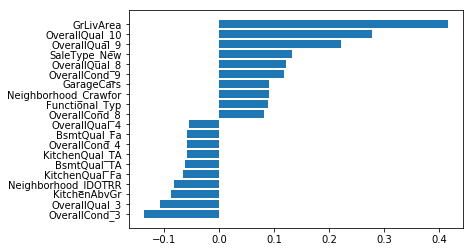

In [467]:
coef_sorted = pd.Series(lasso.coef_, index=x.columns).sort_values(ascending=False)
top_coef = pd.concat([coef_sorted.head(10), coef_sorted.tail(10)]).sort_values()
plt.barh(top_coef.index, top_coef.values)

In [399]:
lasso.alpha_

0.0005

### GBM

In [34]:
from sklearn.ensemble import GradientBoostingRegressor

#### Train

Selecting default parameters:
min_samples_split is approximatly 1% of total number of observations
min_samples_leaf should be lower than min_samples_split
max_features sqrt is the thumb-rule
max_depth based on intuition

In [72]:
gbm = GradientBoostingRegressor(n_estimators=1000, max_features='sqrt', min_samples_split=100, min_samples_leaf=10, max_depth=7, subsample=0.8, learning_rate=0.1)
gbm.fit(x, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=7,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=10, min_samples_split=100,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=None, subsample=0.8, verbose=0,
             warm_start=False)

#### Results

In [73]:
print('R2 = {}'.format(gbm.score(x, y)))
print('RMSE = {}'.format(rmse_cv(gbm).mean()))

R2 = 0.9977070322181906
RMSE = 0.1258815448571864


#### Feature Importance

In [290]:
len(x.columns)

254

In [310]:
feature_importance_gbm = pd.Series(gbm.feature_importances_, index=x.columns).sort_values(ascending=False)
feature_importance_gbm[:25]

LotGrBsmtArea           0.038585
GrLivAreaCubic          0.035524
GrLivAreaSquare         0.035515
GrLivArea               0.035299
1stFlrSF                0.034998
TotalBsmtSF             0.031668
YearBuilt               0.031583
LotArea                 0.029132
GarageYrBlt             0.027758
YearRemodAdd            0.026821
GarageArea              0.025484
BsmtFinSF1              0.023076
BsmtUnfSF               0.020944
OverallCond_3           0.020569
OpenPorchSF             0.018019
LotFrontage             0.015838
2ndFlrSF                0.014267
Neighborhood_Crawfor    0.013084
GarageCars              0.013046
Functional_Typ          0.012871
OverallCond_4           0.012008
OverallCond_7           0.011928
MoSold                  0.011892
EnclosedPorch           0.011600
Exterior1st_BrkFace     0.011548
dtype: float64

<BarContainer object of 20 artists>

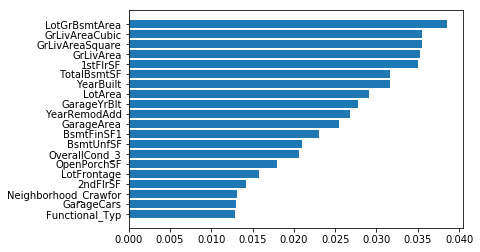

In [302]:
feature_top20 = feature_importance_gbm[:20].sort_values()
plt.barh(feature_top20.index, feature_top20.values)

#### Tuning parameters with GridSearch

In [76]:
from sklearn.model_selection import GridSearchCV

##### First Attempt (n_estimators)

Train

In [79]:
param_test1 = {'n_estimators':range(200,1501,10)}
gsearch1_gbm = GridSearchCV(gbm, param_grid=param_test1, scoring='neg_mean_squared_error', n_jobs=-1, iid=False, cv=5)
gsearch1_gbm.fit(x, y)
gsearch1_gbm.grid_scores_, gsearch1_gbm.best_params_, gsearch1_gbm.best_score_

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.01559, std: 0.00146, params: {'n_estimators': 200},
  mean: -0.01517, std: 0.00165, params: {'n_estimators': 210},
  mean: -0.01599, std: 0.00088, params: {'n_estimators': 220},
  mean: -0.01514, std: 0.00166, params: {'n_estimators': 230},
  mean: -0.01557, std: 0.00140, params: {'n_estimators': 240},
  mean: -0.01547, std: 0.00152, params: {'n_estimators': 250},
  mean: -0.01547, std: 0.00166, params: {'n_estimators': 260},
  mean: -0.01514, std: 0.00174, params: {'n_estimators': 270},
  mean: -0.01590, std: 0.00126, params: {'n_estimators': 280},
  mean: -0.01609, std: 0.00150, params: {'n_estimators': 290},
  mean: -0.01554, std: 0.00157, params: {'n_estimators': 300},
  mean: -0.01541, std: 0.00150, params: {'n_estimators': 310},
  mean: -0.01585, std: 0.00136, params: {'n_estimators': 320},
  mean: -0.01563, std: 0.00152, params: {'n_estimators': 330},
  mean: -0.01552, std: 0.00122, params: {'n_estimators': 340},
  mean: -0.01575, std: 0.00137, params: {'n_estimators'

Results

In [80]:
print('R2 = {}'.format(gsearch1_gbm.best_estimator_.score(x, y)))
print('RMSE = {}'.format(rmse_cv(gsearch1_gbm.best_estimator_).mean()))

R2 = 0.9844884116047558
RMSE = 0.124422147126992


##### Second Attempt (max_depth and min_samples_split)

In [94]:
param_test2 = {'max_depth':range(3,12,2), 'min_samples_split':range(20,121,20)}
gsearch2_gbm = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=380, max_features='sqrt', subsample=0.8, min_samples_leaf=10), 
param_grid = param_test2, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch2_gbm.fit(x,y)
gsearch2_gbm.grid_scores_, gsearch2_gbm.best_params_, gsearch2_gbm.best_score_

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.01493, std: 0.00135, params: {'max_depth': 3, 'min_samples_split': 20},
  mean: -0.01460, std: 0.00131, params: {'max_depth': 3, 'min_samples_split': 40},
  mean: -0.01507, std: 0.00173, params: {'max_depth': 3, 'min_samples_split': 60},
  mean: -0.01518, std: 0.00121, params: {'max_depth': 3, 'min_samples_split': 80},
  mean: -0.01515, std: 0.00175, params: {'max_depth': 3, 'min_samples_split': 100},
  mean: -0.01514, std: 0.00099, params: {'max_depth': 3, 'min_samples_split': 120},
  mean: -0.01501, std: 0.00183, params: {'max_depth': 5, 'min_samples_split': 20},
  mean: -0.01569, std: 0.00153, params: {'max_depth': 5, 'min_samples_split': 40},
  mean: -0.01565, std: 0.00176, params: {'max_depth': 5, 'min_samples_split': 60},
  mean: -0.01494, std: 0.00138, params: {'max_depth': 5, 'min_samples_split': 80},
  mean: -0.01570, std: 0.00153, params: {'max_depth': 5, 'min_samples_split': 100},
  mean: -0.01543, std: 0.00140, params: {'max_depth': 5, 'min_samples_split': 120},


Results

In [95]:
print('R2 = {}'.format(gsearch2_gbm.best_estimator_.score(x, y)))
print('RMSE = {}'.format(rmse_cv(gsearch2_gbm.best_estimator_).mean()))

R2 = 0.9593991505555762
RMSE = 0.12177661497642918


##### Third Attempt (min_samples_leaf and min_samples_split)

In [96]:
param_test3 = {'min_samples_split':range(20,161,20), 'min_samples_leaf':range(10,61,10)}
gsearch3_gbm = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=380, max_features='sqrt', subsample=0.8, max_depth=3), 
param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch3_gbm.fit(x,y)
gsearch3_gbm.grid_scores_, gsearch3_gbm.best_params_, gsearch3_gbm.best_score_

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.01535, std: 0.00109, params: {'min_samples_leaf': 10, 'min_samples_split': 20},
  mean: -0.01481, std: 0.00179, params: {'min_samples_leaf': 10, 'min_samples_split': 40},
  mean: -0.01484, std: 0.00158, params: {'min_samples_leaf': 10, 'min_samples_split': 60},
  mean: -0.01466, std: 0.00105, params: {'min_samples_leaf': 10, 'min_samples_split': 80},
  mean: -0.01559, std: 0.00163, params: {'min_samples_leaf': 10, 'min_samples_split': 100},
  mean: -0.01503, std: 0.00164, params: {'min_samples_leaf': 10, 'min_samples_split': 120},
  mean: -0.01528, std: 0.00138, params: {'min_samples_leaf': 10, 'min_samples_split': 140},
  mean: -0.01494, std: 0.00134, params: {'min_samples_leaf': 10, 'min_samples_split': 160},
  mean: -0.01597, std: 0.00161, params: {'min_samples_leaf': 20, 'min_samples_split': 20},
  mean: -0.01579, std: 0.00118, params: {'min_samples_leaf': 20, 'min_samples_split': 40},
  mean: -0.01570, std: 0.00142, params: {'min_samples_leaf': 20, 'min_samples_split': 

In [129]:
print('R2 = {}'.format(gsearch3_gbm.best_estimator_.score(x, y)))
print('RMSE = {}'.format(rmse_cv(gsearch3_gbm.best_estimator_).mean()))

R2 = 0.9564891048272538
RMSE = 0.12342047303647943


##### Forth Attempt (max_features)

In [104]:
param_test4 = {'max_features':range(7,20,2)}
gsearch4_gbm = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=380, min_samples_split=80, min_samples_leaf=10, subsample=0.8, max_depth=7), 
param_grid = param_test4, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch4_gbm.fit(x,y)
gsearch4_gbm.grid_scores_, gsearch4_gbm.best_params_, gsearch4_gbm.best_score_

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.01557, std: 0.00204, params: {'max_features': 7},
  mean: -0.01575, std: 0.00189, params: {'max_features': 9},
  mean: -0.01631, std: 0.00185, params: {'max_features': 11},
  mean: -0.01551, std: 0.00147, params: {'max_features': 13},
  mean: -0.01562, std: 0.00200, params: {'max_features': 15},
  mean: -0.01496, std: 0.00176, params: {'max_features': 17},
  mean: -0.01578, std: 0.00182, params: {'max_features': 19}],
 {'max_features': 17},
 -0.01495935369113261)

In [127]:
print('R2 = {}'.format(gsearch4_gbm.best_estimator_.score(x, y)))
print('RMSE = {}'.format(rmse_cv(gsearch4_gbm.best_estimator_).mean()))

R2 = 0.9888047770339554
RMSE = 0.1261835044588583


#### Fifth Attempt (subsample)

In [117]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5_gbm = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=380,max_depth=7,min_samples_split=80, min_samples_leaf=10, subsample=0.8, max_features=13),
param_grid = param_test5, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=10)
gsearch5_gbm.fit(x, y)
gsearch5_gbm.grid_scores_, gsearch5_gbm.best_params_, gsearch5_gbm.best_score_

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.01546, std: 0.00310, params: {'subsample': 0.6},
  mean: -0.01537, std: 0.00391, params: {'subsample': 0.7},
  mean: -0.01537, std: 0.00409, params: {'subsample': 0.75},
  mean: -0.01539, std: 0.00406, params: {'subsample': 0.8},
  mean: -0.01535, std: 0.00342, params: {'subsample': 0.85},
  mean: -0.01556, std: 0.00453, params: {'subsample': 0.9}],
 {'subsample': 0.85},
 -0.015352018648432724)

In [126]:
print('R2 = {}'.format(gsearch5_gbm.best_estimator_.score(x, y)))
print('RMSE = {}'.format(rmse_cv(gsearch5_gbm.best_estimator_).mean()))

R2 = 0.9878610628143983
RMSE = 0.12544152637119224


#### Final Attempt

In [400]:
gbm = GradientBoostingRegressor(learning_rate=0.05, n_estimators=760, min_samples_split=80, min_samples_leaf=10, subsample=0.85, max_depth=7)
gbm.fit(x, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=7, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=10,
             min_samples_split=80, min_weight_fraction_leaf=0.0,
             n_estimators=760, presort='auto', random_state=None,
             subsample=0.85, verbose=0, warm_start=False)

In [401]:
print('R2 = {}'.format(gbm.score(x, y)))
print('RMSE = {}'.format(rmse_cv(gbm).mean()))

R2 = 0.9962930230790022
RMSE = 0.12520170995560514


### XGBoost

In [131]:
from xgboost import XGBRegressor

#### Train

In [153]:
xgboost = XGBRegressor(learning_rate=0.01, n_estimators=1000, random_state=10)
xgboost.fit(x, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=10,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

#### Results

In [154]:
print('R2 = {}'.format(xgboost.score(x, y)))
print('RMSE = {}'.format(rmse_cv(xgboost).mean()))

R2 = 0.9476474563331247
RMSE = 0.12964034276402114


#### Feature Importance

In [155]:
feature_importance_xgboost = pd.Series(xgboost.feature_importances_, index=x.columns).sort_values(ascending=False)
feature_importance_xgboost[:10]

GrLivArea       0.079259
LotArea         0.067608
TotalBsmtSF     0.045896
YearBuilt       0.043071
BsmtFinSF1      0.039365
GarageArea      0.038658
1stFlrSF        0.030715
YearRemodAdd    0.028773
GarageYrBlt     0.024537
OpenPorchSF     0.023301
dtype: float32

<BarContainer object of 20 artists>

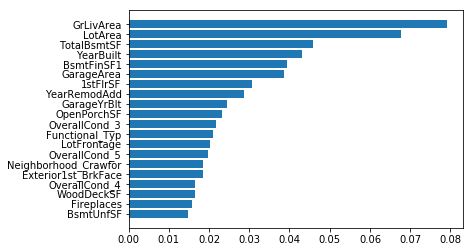

In [156]:
feature_top20 = feature_importance_xgboost[:20].sort_values()
plt.barh(feature_top20.index, feature_top20.values)

#### Tuning parameters with Bayesian Optimization

In [426]:
x['LotGrBsmtArea'] = x['GrLivArea'] * x['LotArea'] * x['TotalBsmtSF']
x['GrLivAreaSquare'] = x['GrLivArea']**2
x['GrLivAreaCubic'] = x['GrLivArea']**3
x['Q406'] = ((x['MoSold'] == 10) | (x['MoSold'] == 11) | (x['MoSold'] == 12) & (x['YrSold'] == 2006))
x['Q407'] = ((x['MoSold'] == 10) | (x['MoSold'] == 11) | (x['MoSold'] == 12) & (x['YrSold'] == 2007))
x['Q408'] = ((x['MoSold'] == 10) | (x['MoSold'] == 11) | (x['MoSold'] == 12) & (x['YrSold'] == 2008))
x['Q409'] = ((x['MoSold'] == 10) | (x['MoSold'] == 11) | (x['MoSold'] == 12) & (x['YrSold'] == 2009))
x['Q410'] = ((x['MoSold'] == 10) | (x['MoSold'] == 11) | (x['MoSold'] == 12) & (x['YrSold'] == 2010))

In [203]:
def xgboostcv(max_depth, min_child_weight, gamma, colsample_bytree, subsample, reg_alpha, n_estimators):
    val = cross_val_score(
        XGBRegressor(max_depth=int(max_depth),
            min_child_weight=int(min_child_weight),
            gamma= max(gamma, 0),
            colsample_bytree=max(min(colsample_bytree, 1), 0),
            subsample=max(min(subsample, 1), 0),
            reg_alpha=max(reg_alpha, 0),
            learning_rate=0.01,
            n_estimators=int(n_estimators),
            random_state=10
        ),
        x, y, scoring='neg_mean_squared_error', cv=5
    ).mean()
    return val

In [204]:
from bayes_opt import BayesianOptimization

In [205]:
gp_params = {"alpha": 1e-5}

In [206]:
xgboostBO = BayesianOptimization(
        xgboostcv,
        {'min_child_weight': (1, 20),
         'colsample_bytree': (0.1, 1),
         'max_depth': (5, 15),
         'subsample': (0.5, 1),
         'gamma': (0, 0.5),
         'reg_alpha': (0, 10),
         'n_estimators':(200, 1100)
        }
    )

In [207]:
xgboostBO.maximize(n_iter=10, **gp_params)

Initialization
----------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   n_estimators |   reg_alpha |   subsample | 
    1 | 00m05s |   -0.02882 |             0.1168 |    0.1449 |     14.1819 |            18.7132 |       766.3116 |      7.3060 |      0.7353 | 
    2 | 00m14s |   -0.02734 |             0.4886 |    0.3387 |      7.6572 |            12.3557 |       652.8658 |      5.0125 |      0.6763 | 
    3 | 00m28s |   -0.02134 |             0.5040 |    0.0883 |      9.2821 |            15.3339 |       934.2739 |      4.0382 |      0.8542 | 
    4 | 00m04s |   -1.22807 |             0.9820 |    0.3605 |      6.0807 |             4.9991 |       238.9891 |      7.7231 |      0.8645 | 
    5 | 00m51s |   -0.02027 |             0.6585 |    0.2655 |     14.6669 |             7.6877 |       983.3159 |      0.

In [208]:
print('XGBoost: %f' % xgboostBO.res['max']['max_val'])

XGBoost: -0.015799


In [402]:
xgboost = XGBRegressor(learning_rate=0.01, n_estimators=1050, max_depth=5, min_child_weight=20, gamma=0, colsample_bytree=1, subsample=1, reg_alpha=0, random_state=10)
xgboost.fit(x, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=5, min_child_weight=20, missing=None, n_estimators=1050,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=10,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [403]:
print('R2 = {}'.format(xgboost.score(x, y)))
print('RMSE = {}'.format(rmse_cv(xgboost).mean()))

R2 = 0.9577296156489108
RMSE = 0.1266189553082544


In [231]:
def gbmcv(max_depth, max_features, min_samples_leaf, min_samples_split, subsample, n_estimators):
    val = cross_val_score(
        GradientBoostingRegressor(max_depth=int(max_depth),
            max_features=int(max_features),
            min_samples_leaf= max(min(min_samples_leaf, 1), 0),
            min_samples_split=max(min(min_samples_split, 2), 0),
            subsample=max(min(subsample, 1), 0),
            n_estimators=int(n_estimators),
            learning_rate=0.01,
            random_state=10
        ),
        x, y, scoring='neg_mean_squared_error', cv=5
    ).mean()
    return val

In [232]:
gbmBO = BayesianOptimization(
        gbmcv,
        {'max_features': (4, 20),
         'min_samples_leaf': (10, 60),
         'max_depth': (3, 15),
         'subsample': (0.5, 1),
         'min_samples_split': (20, 120),
         'n_estimators':(200, 1200)
        }
    )

In [233]:
gbmBO.maximize(n_iter=15, **gp_params)

Initialization
--------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   max_depth |   max_features |   min_samples_leaf |   min_samples_split |   n_estimators |   subsample | 
    1 | 00m08s |   -0.01593 |      8.1509 |        12.8725 |            30.0692 |             88.5846 |       705.7768 |      0.7523 | 
    2 | 00m03s |   -0.02117 |     12.1065 |         5.6966 |            27.8477 |             24.5862 |       309.2079 |      0.6533 | 
    3 | 00m11s |   -0.01712 |      9.7380 |        14.8333 |            51.1682 |             38.6978 |       608.9703 |      0.9037 | 
    4 | 00m03s |   -0.01563 |      4.9762 |         8.3618 |            26.6382 |             84.8744 |       996.0290 |      0.8818 | 
    5 | 00m21s |   -0.01650 |     13.4217 |        14.9990 |            56.3629 |             21.6501 |       989.3350 |      0.5065 | 
Bayesian Optimization
------------

In [404]:
gbm = GradientBoostingRegressor(n_estimators=1200, max_features=12, min_samples_split=20, min_samples_leaf=11, max_depth=6, subsample=0.7, learning_rate=0.01,random_state=10)
gbm.fit(x, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=6, max_features=12,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=11,
             min_samples_split=20, min_weight_fraction_leaf=0.0,
             n_estimators=1200, presort='auto', random_state=10,
             subsample=0.7, verbose=0, warm_start=False)

In [405]:
print('R2 = {}'.format(gbm.score(x, y)))
print('RMSE = {}'.format(rmse_cv(gbm).mean()))

R2 = 0.966802503817514
RMSE = 0.11943455910421456


In [307]:
from sklearn.metrics import mean_squared_error
print('RMSE Train = {}'.format(np.sqrt(mean_squared_error(y, gbm.predict(x)))))

RMSE Train = 0.0728038901740424


### Residuals Plot

In [249]:
from scipy import stats 

In [319]:
test = pd.DataFrame({'y':y, 'resid':y - lasso.predict(x)})
test = pd.concat([test, x], axis=1)

test[test['resid'] < -0.4]

,resid,y,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleCondition_Normal,SaleCondition_Partial,LotGrBsmtArea,GrLivAreaSquare,GrLivAreaCubic,Q406,Q407,Q408,Q409,Q410
30,-0.722433,10.596635,3.931826,9.047939,7.560601,7.576097,0.000000,0.000000,0.000000,6.476972,...,1,0,420.998181,51.607998,370.745189,False,False,False,False,False
462,-0.614572,11.041048,4.110874,9.021840,7.583756,7.583756,0.000000,6.317165,5.743003,0.000000,...,1,0,412.609424,45.734510,309.290123,False,False,False,False,False
495,-0.593084,10.460242,4.110874,8.972083,7.560601,7.576097,0.000000,6.206576,0.000000,5.420535,...,0,0,388.534371,43.304811,284.973337,False,False,False,False,False
588,-0.403810,11.870600,4.189655,10.130464,7.585281,7.602900,0.000000,7.189168,0.000000,4.736198,...,0,1,537.394277,53.227750,388.335564,False,False,False,False,False
632,-0.665650,11.320554,4.454347,9.384378,7.589842,7.589842,5.347108,6.712956,0.000000,6.336826,...,0,0,492.426446,52.602563,381.513890,False,False,False,False,False
812,-0.424005,10.932982,4.204693,9.072571,7.577122,7.577122,0.000000,0.000000,0.000000,6.293419,...,0,0,396.928784,48.327136,335.959240,False,False,False,False,False
916,-0.470163,10.471950,3.931826,9.105091,7.575585,7.576097,0.000000,3.931826,0.000000,6.066108,...,0,0,347.280339,38.141337,235.555832,False,False,False,False,False
968,-0.602810,10.542706,3.931826,8.687105,7.555382,7.576097,0.000000,0.000000,0.000000,6.398595,...,0,0,382.218986,47.283015,325.130523,False,False,False,False,False
1324,-0.622221,11.898188,4.330733,9.209040,7.604396,7.604894,6.061457,0.000000,0.000000,7.493317,...,0,1,517.085759,56.149803,420.748290,False,False,False,False,False
1432,-0.417554,11.074421,4.110874,9.287394,7.564238,7.604894,0.000000,0.000000,0.000000,6.487684,...,1,0,414.320231,47.283015,325.130523,False,False,False,False,False


In [321]:
import statsmodels.api as sm
import pylab

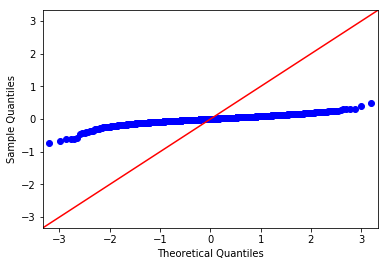

In [324]:
sm.qqplot(test['resid'], line='45')
pylab.show()

0.08254135588051738 -0.9924779779951165 0.3135556257096141


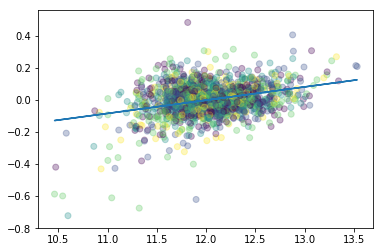

In [281]:
plt.scatter(test['y'], test['resid'], c=test['year'], alpha=0.3, label=test['year'])
slope, intercept, r_value, p_value, std_err = stats.linregress(y, test['resid'])
print(slope, intercept, r_value)
y_fit = intercept + slope*y
plt.plot(y, y_fit)

0.06210383880200998 -0.7464065359725621 0.30206740403251514


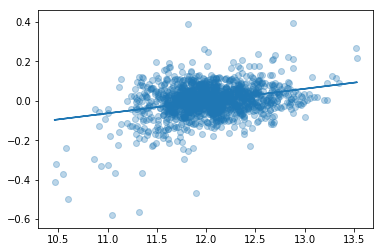

In [251]:
plt.scatter(y, y - xgboost.predict(x), alpha=0.3)
slope, intercept, r_value, p_value, std_err = stats.linregress(y, y - xgboost.predict(x))
print(slope, intercept, r_value)
y_fit = intercept + slope*y
plt.plot(y, y_fit)

0.051304120426080305 -0.616737144538831 0.2815791097667614 5.621268309950351e-28


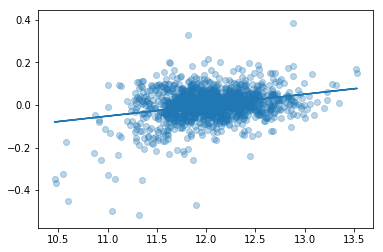

In [303]:
plt.scatter(y, y - gbm.predict(x), alpha=0.3)
slope, intercept, r_value, p_value, std_err = stats.linregress(y, y - gbm.predict(x))
print(slope, intercept, r_value, p_value)
y_fit = intercept + slope*y
plt.plot(y, y_fit)

### Ensemble

In [261]:
y_gbm = gbm.predict(x)
y_xgboost = xgboost.predict(x)
y_lasso = lasso.predict(x)

In [340]:
z = 0.5*y_gbm + 0.2*y_xgboost + 0.3*y_lasso

In [339]:
print('RMSE Train = {}'.format(np.sqrt(mean_squared_error(y, z))))

RMSE Train = 0.08123225696786797


0.0775091763613307 -0.9319203206182222 0.317523885975729 1.6434081583482733e-35


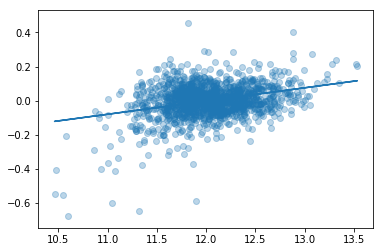

In [272]:
plt.scatter(y, y - z, alpha=0.3)
slope, intercept, r_value, p_value, std_err = stats.linregress(y, y - z)
print(slope, intercept, r_value, p_value)
y_fit = intercept + slope*y
plt.plot(y, y_fit)

### Final Results

In [432]:
test = pd.read_csv('../test_wo_missing_values.csv')

In [407]:
%reload_ext autoreload

In [435]:
from transform_full import transform_dataset_test

In [436]:
test = transform_dataset_test(test)

In [447]:
test['LotGrBsmtArea'] = test['GrLivArea'] * test['LotArea'] * test['TotalBsmtSF']
test['GrLivAreaSquare'] = test['GrLivArea']**2
test['GrLivAreaCubic'] = test['GrLivArea']**3
test['Q406'] = ((test['MoSold'] == 10) | (test['MoSold'] == 11) | (test['MoSold'] == 12) & (test['YrSold'] == 2006))
test['Q407'] = ((test['MoSold'] == 10) | (test['MoSold'] == 11) | (test['MoSold'] == 12) & (test['YrSold'] == 2007))
test['Q408'] = ((test['MoSold'] == 10) | (test['MoSold'] == 11) | (test['MoSold'] == 12) & (test['YrSold'] == 2008))
test['Q409'] = ((test['MoSold'] == 10) | (test['MoSold'] == 11) | (test['MoSold'] == 12) & (test['YrSold'] == 2009))
test['Q410'] = ((test['MoSold'] == 10) | (test['MoSold'] == 11) | (test['MoSold'] == 12) & (test['YrSold'] == 2010))

In [434]:
test.drop(columns=['Id'], inplace=True)


In [445]:
x.loc[:,'MSZoning_No']

KeyError: 'the label [MSZoning_No] is not in the [columns]'

In [448]:
x.drop(columns=test.columns)


ValueError: labels ['MSSubClass_150' 'MSZoning_No' 'Utilities_No' 'Exterior1st_No'
 'Exterior2nd_No' 'BsmtFinType1_No' 'KitchenQual_No' 'Functional_No'
 'SaleType_No'] not contained in axis

In [449]:
test.drop(columns=x.columns)


ValueError: labels ['Utilities_NoSeWa' 'Condition2_RRAe' 'Condition2_RRAn' 'Condition2_RRNn'
 'HouseStyle_2.5Fin' 'RoofMatl_Membran' 'RoofMatl_Metal' 'RoofMatl_Roll'
 'Exterior1st_ImStucc' 'Exterior1st_Stone' 'Exterior2nd_Other'
 'Heating_GasA' 'Heating_OthW' 'Electrical_Mix'] not contained in axis

In [442]:
y_gbm = gbm.predict(test)
y_xgboost = xgboost.predict(test)
y_rf = lasso.predict(test)

ValueError: Number of features of the model must match the input. Model n_features is 259 and input n_features is 246 

In [ ]:
z = 0.5*y_gbm + 0.2*y_xgboost + 0.3*y_lasso

In [ ]:
test_original = pd.read_csv('../test.csv')

In [ ]:
final_df = pd.DataFrame({'Id':test_original['Id'], 'SalePrice':np.exp(z)})

In [ ]:
final_df.to_csv("../submit.csv", float_format='%f', index=False) 